# Feature Extraction - ResNest50

### Use GPU if available

In [1]:
import tensorflow as tf

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# List physical devices
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.16.2
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Enable memory growth for the GPU

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)

GPU memory growth enabled


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from os import walk

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import regularizers # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # type: ignore
from tensorflow.keras.applications import ResNet50 # type: ignore


# Data Processing

## import data

In [ ]:
# Define dataset directories
base_dir = '../../data/dataset'
train_dir = f'{base_dir}/train'
val_dir = f'{base_dir}/validation'
test_dir = f'{base_dir}/test'
target_size = 224

In [5]:
classes = ['Trousers', 'Dress', 'Sweater', 'T-shirt', 'Top', 'Blouse']

### Data Augmentation

In [6]:
# For training: include data augmentation
train_datagen = ImageDataGenerator(
  rescale = 1./255,  # Normalize pixel values to [0, 1]
  rotation_range = 20,  # Randomly rotate images by up to 20 degrees
  width_shift_range = 0.2,  # Randomly shift images horizontally
  height_shift_range = 0.2,  # Randomly shift images vertically
  shear_range = 0.15,  # Apply shear transformations
  zoom_range = 0.15,  # Apply zoom transformations
  horizontal_flip = True  # Randomly flip images horizontally
)

# For validation and testing: no augmentation, only rescale
val_test_datagen = ImageDataGenerator(rescale=1./255)

### Load Images as 224 x 224 (for CNN)

In [7]:
# Load images function
def load_images(folder_path, image_size=(224, 224)):
    images = []
    labels = []
    paths = []

    for class_folder in os.listdir(folder_path):
        
        if class_folder == '.DS_Store': continue
        class_path = os.path.join(folder_path, class_folder)
        
        for file in os.listdir(class_path):
            file_path = os.path.join(class_path, file)
            image = cv2.imread(file_path)  # Load as RGB
            image = cv2.resize(image, image_size)
            images.append(image)
            labels.append(class_folder)
            paths.append(file_path)
    return np.array(images), np.array(labels), np.array(paths)

In [8]:
# Load training, validation, and test data
train_images, train_labels, train_paths = load_images(train_dir)
val_images, val_labels, val_paths = load_images(val_dir)
test_images, test_labels, test_paths = load_images(test_dir)

In [9]:
train_paths[0]

'../data/dataset/train/0/0772176001.jpg'

### Normalize Pictures
Normalize pixel values to [0, 1]

In [10]:
# Convert images to a format suitable for model training (if not using generators)
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0

### View Dataset Images

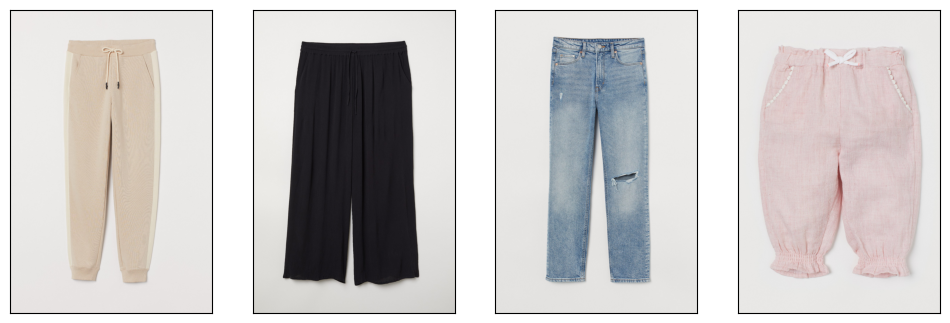

In [11]:
def show_images(folder, no_images=3):
    # Construct the folder path dynamically based on the 'folder' argument
    folder_path = os.path.join(train_dir, folder)  # Dynamically create the folder path

    # Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"Error: The folder '{folder}' does not exist!")
        return

    # Extract image names from the folder
    files = []
    for _, _, filenames in walk(folder_path):
        files.extend(filenames)

    no_files = len(files)

    if no_files == 0:
        print(f"Error: No images found in the folder '{folder}'.")
        return

    if no_images > no_files:
        no_images = no_files
        print("Warning! Less images than requested.")

    # Plot selected number of images
    images = files[:no_images]
    fig, ax = plt.subplots(1, no_images, figsize=(12, 4))

    # If only one image is shown, ax will not be a list but a single Axes object
    if no_images == 1:
        ax = [ax]

    # Loop through the selected images and display them
    for i, img in enumerate(images):
        img_path = os.path.join(folder_path, img)
        img_data = plt.imread(img_path)
        ax[i].imshow(img_data, aspect='equal')
        ax[i].grid(False)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.show()

# Example usage: show 4 images from folder '0'
show_images('0', 4)

# Part 1 : Train and fine-tune ResNest50 Model


## Model Fine-tuning

### Load and Compile model

In [12]:
# Load a pre-trained model (ResNet50)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False  # We are not training the base model initially

#  Add custom layers for fine-tuning
x = base_model.output
x = Flatten()(x)  # Flatten the output of the base model
x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)  # Add a dense layer
x = Dropout(0.5)(x)  # Add dropout for regularization
x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)  # Another dense layer
x = Dense(6, activation='softmax')(x)  # Assuming 6 classes in the output layer

# Create the full model
model = Model(inputs = base_model.input, outputs = x)

# Compile the model
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])


2024-12-07 02:04:13.292113: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-12-07 02:04:13.292131: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-12-07 02:04:13.292134: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-12-07 02:04:13.292149: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-07 02:04:13.292158: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Data Generators

In [13]:
# Prepare data generators
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True)

val_test_datagen = ImageDataGenerator(rescale = 1./255)

# Load data using the ImageDataGenerator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (224, 224),
                                                    batch_size = 32,
                                                    class_mode = 'sparse')

val_generator = val_test_datagen.flow_from_directory(val_dir,
                                                     target_size = (224, 224),
                                                     batch_size = 32,
                                                     class_mode = 'sparse')

Found 4200 images belonging to 6 classes.
Found 900 images belonging to 6 classes.


### Initial Fine-Tuning

In [14]:
# Start fine-tuning the model for a few epochs
history = model.fit(train_generator, epochs = 5, validation_data = val_generator)

/Users/reem/Library/Mobile Documents/com~apple~CloudDocs/College/9th semester/CPCS-432/Project/vanilla/venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


2024-12-07 02:04:15.863240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 320ms/step - accuracy: 0.1927 - loss: 25.5414 - val_accuracy: 0.3044 - val_loss: 13.0597
Epoch 2/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 40s 305ms/step - accuracy: 0.2192 - loss: 17.2556 - val_accuracy: 0.2944 - val_loss: 12.0223
Epoch 3/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 41s 308ms/step - accuracy: 0.2464 - loss: 15.7881 - val_accuracy: 0.2800 - val_loss: 11.3826
Epoch 4/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 41s 307ms/step - accuracy: 0.2407 - loss: 13.5175 - val_accuracy: 0.2511 - val_loss: 11.4631
Epoch 5/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 41s 307ms/step - accuracy: 0.2685 - loss: 12.2671 - val_accuracy: 0.2833 - val_loss: 10.5027


### Fine-tune model

In [ ]:
# Now gradually unfreeze layers: unfreeze the top 20 layers first
for layer in base_model.layers[:20]:
    layer.trainable = False

for layer in base_model.layers[20:]:
    layer.trainable = True

# Recompile the model after making changes to the trainable layers
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# Define EarlyStopping and ReduceLROnPlateau
early_stopping = EarlyStopping(
    monitor = 'val_loss',    # Monitor validation loss for early stopping
    patience = 3,            # Number of epochs with no improvement to wait
    verbose = 1,             # Print message when stopping
    restore_best_weights = True  # Restore the best weights after stopping
)

checkpoint_callback = ModelCheckpoint(
    '../../models/best_model_after_finetune.keras',  # Path to save the model
    monitor = 'val_loss',              # Monitor validation loss to save the best model
    save_best_only = True,             # Save only the best model (based on monitored metric)
    save_weights_only = False,         # Save the entire model (including architecture)
    verbose = 1                        # Print message when saving
)

# Continue fine-tuning with the gradually unfrozen layers
history = model.fit(
    train_generator,       # Training data
    epochs = 200,             # Total number of epochs
    validation_data = val_generator,  # Validation data
    callbacks = [early_stopping, checkpoint_callback]  # Add all callbacks
)

Epoch 1/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.3501 - loss: 11.3309
Epoch 1: val_loss improved from inf to 10.04064, saving model to ../models/best_model_after_finetune.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 98s 530ms/step - accuracy: 0.3506 - loss: 11.3262 - val_accuracy: 0.3000 - val_loss: 10.0406
Epoch 2/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.5765 - loss: 9.3536
Epoch 2: val_loss improved from 10.04064 to 9.22296, saving model to ../models/best_model_after_finetune.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 70s 531ms/step - accuracy: 0.5765 - loss: 9.3531 - val_accuracy: 0.4533 - val_loss: 9.2230
Epoch 3/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.6144 - loss: 8.7630
Epoch 3: val_loss improved from 9.22296 to 8.07897, saving model to ../models/best_model_after_finetune.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 78s 591ms/step - accuracy: 0.6146 - loss: 8.7616 - val_accuracy: 0.7278 - val_loss: 8.0790
Epoch 4/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0

### Training and Validation Loss Graph

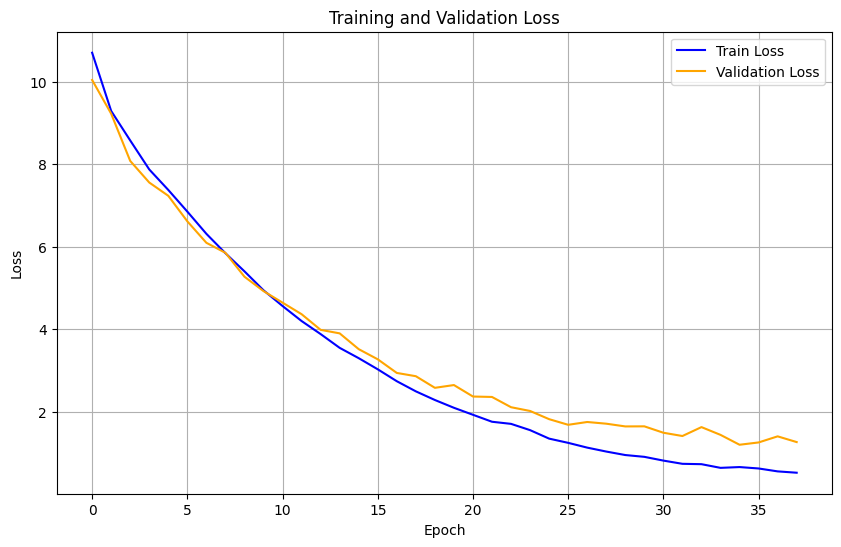

In [16]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Accuracy Graph

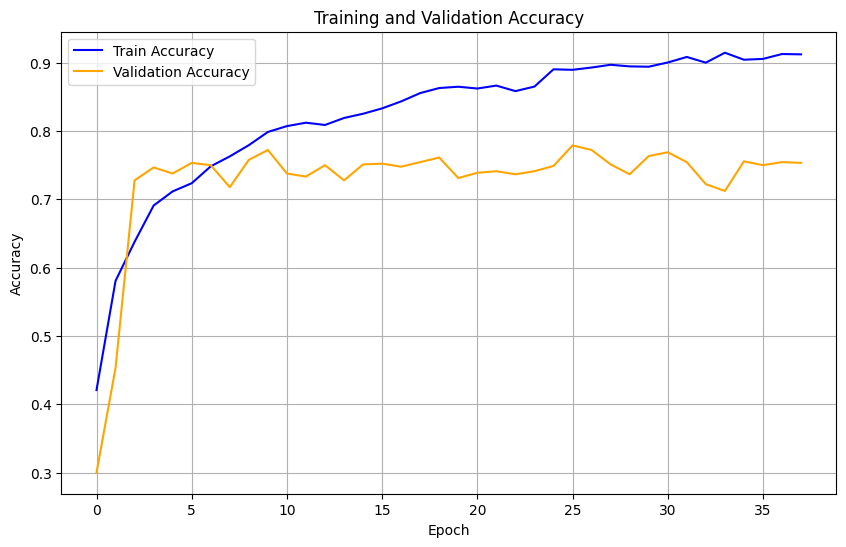

In [17]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

 ### Performance Metrics

 accuracy, precision, recall F1-score, Confusion Matrix

In [18]:
# Step 1: Initialize the true labels and predictions lists
true_labels = []
predictions = []
confidences = []

# Step 2: Loop through the validation generator to get both true labels and predictions
for i, (images, labels) in enumerate(val_generator):
    # Step 2.1: Get model predictions for the current batch of images
    val_predictions_prob = model.predict(images, verbose=0)  # Get probabilities for each class
    val_predictions = np.argmax(val_predictions_prob, axis=1)  # Convert probabilities to class labels
    val_confidences = np.max(val_predictions_prob, axis=1)  # Confidence level of predicted classes

    # Step 2.2: Append the true labels, predicted labels, and confidence levels
    true_labels.extend(labels)
    predictions.extend(val_predictions)
    confidences.extend(val_confidences)

    # Optional: Stop early if you want to avoid running over the entire validation set
    if i >= len(val_generator) - 1:  # Adjust this if you want to limit the number of steps
        break

In [19]:
# Step 3: Convert the true_labels, predictions, and confidences to numpy arrays for evaluation
true_labels = np.array(true_labels)
predictions = np.array(predictions)
confidences = np.array(confidences)

# Step 4: Compute classification metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

In [20]:
# Print classification metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


# Step 5: Display a few samples with their predicted class and confidence
print("\nSample predictions with confidence levels:")
for i in range(5):  # Print first 5 samples
    print(f"Sample {i+1} - Predicted Class: {predictions[i]}, Confidence: {confidences[i]:.4f}")

Accuracy: 0.7555555555555555
Precision: 0.7541664113495329
Recall: 0.7555555555555555
F1 Score: 0.7537807919675784

Sample predictions with confidence levels:
Sample 1 - Predicted Class: 5, Confidence: 0.9989
Sample 2 - Predicted Class: 4, Confidence: 0.6844
Sample 3 - Predicted Class: 5, Confidence: 0.9995
Sample 4 - Predicted Class: 3, Confidence: 0.7337
Sample 5 - Predicted Class: 2, Confidence: 0.9589


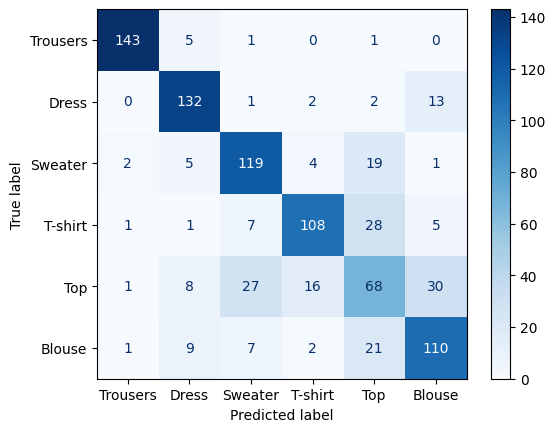

In [21]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

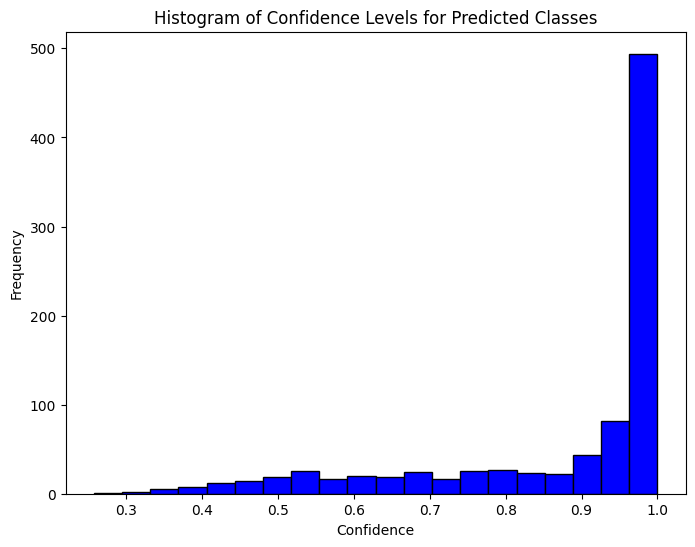

In [22]:
# Step 6: Optional - Plot histogram of confidence levels
plt.figure(figsize=(8, 6))
plt.hist(confidences, bins=20, color='blue', edgecolor='black')
plt.title("Histogram of Confidence Levels for Predicted Classes")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.show()

### Cross-Validation

In [23]:
dd = train_labels.astype(int)

print(f'{dd=}')
print(f'{train_labels=}')

dd=array([0, 0, 0, ..., 5, 5, 5])
train_labels=array(['0', '0', '0', ..., '5', '5', '5'], dtype='<U1')


In [24]:
# Cross-validation
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
cv_scores = []

for train_index, val_index in kfold.split(train_images, train_labels):
    train_fold_images, val_fold_images = train_images[train_index], train_images[val_index]
    train_fold_labels, val_fold_labels = train_labels[train_index], train_labels[val_index]
    train_fold_labels = train_fold_labels.astype(int)
    val_fold_labels = val_fold_labels.astype(int)

    # Train model with this fold
    model.fit(train_fold_images, train_fold_labels, epochs = 10, validation_data = (val_fold_images, val_fold_labels))

    # Evaluate on the validation fold
    val_pred = model.predict(val_fold_images)
    val_pred = np.argmax(val_pred, axis=1)

    # Calculate metrics
    cv_accuracy = accuracy_score(val_fold_labels, val_pred)
    cv_scores.append(cv_accuracy)

# Print the cross-validation results
print(f"Cross-validation results: Mean accuracy = {np.mean(cv_scores):.4f}, Std = {np.std(cv_scores):.4f}")

Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 96s 599ms/step - accuracy: 0.9428 - loss: 0.4797 - val_accuracy: 0.9333 - val_loss: 0.5033
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 51s 488ms/step - accuracy: 0.9782 - loss: 0.3465 - val_accuracy: 0.9452 - val_loss: 0.4385
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 54s 516ms/step - accuracy: 0.9669 - loss: 0.3242 - val_accuracy: 0.9369 - val_loss: 0.4130
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 55s 527ms/step - accuracy: 0.9843 - loss: 0.2473 - val_accuracy: 0.9155 - val_loss: 0.4672
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 57s 542ms/step - accuracy: 0.9745 - loss: 0.2604 - val_accuracy: 0.9298 - val_loss: 0.4394
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 57s 543ms/step - accuracy: 0.9899 - loss: 0.2050 - val_accuracy: 0.8964 - val_loss: 0.5377
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 55s 529ms/step - accuracy: 0.9730 - loss: 0.2462 - val_accuracy: 0.9095 - val_loss: 0.5419
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 51s 488ms/step - accuracy: 0.9818 - loss: 0

In [25]:
# Cross-validation
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
cv_scores = []

for train_index, val_index in kfold.split(val_images, val_labels):
    train_fold_images, val_fold_images = train_images[train_index], train_images[val_index]
    train_fold_labels, val_fold_labels = train_labels[train_index], train_labels[val_index]
    train_fold_labels = train_fold_labels.astype(int)
    val_fold_labels = val_fold_labels.astype(int)

    # Train model with this fold
    model.fit(train_fold_images, train_fold_labels, batch_size = 64, epochs = 10, validation_data = (val_fold_images, val_fold_labels))

    # Evaluate on the validation fold
    val_pred = model.predict(val_fold_images)
    val_pred = np.argmax(val_pred, axis=1)

    # Calculate metrics
    cv_accuracy = accuracy_score(val_fold_labels, val_pred)
    cv_scores.append(cv_accuracy)

# Print the cross-validation results
print(f"Cross-validation results: Mean accuracy = {np.mean(cv_scores):.4f}, Std = {np.std(cv_scores):.4f}")

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.9798 - loss: 0.0817 - val_accuracy: 1.0000 - val_loss: 0.0294
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9962 - loss: 0.0367 - val_accuracy: 1.0000 - val_loss: 0.0311
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 771ms/step - accuracy: 1.0000 - loss: 0.0301 - val_accuracy: 1.0000 - val_loss: 0.0264
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 680ms/step - accuracy: 1.0000 - loss: 0.0253 - val_accuracy: 1.0000 - val_loss: 0.0220
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 713ms/step - accuracy: 1.0000 - loss: 0.0212 - val_accuracy: 1.0000 - val_loss: 0.0189
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 695ms/step - accuracy: 1.0000 - loss: 0.0184 - val_accuracy: 1.0000 - val_loss: 0.0168
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 808ms/step - accuracy: 1.0000 - loss: 0.0164 - val_accuracy: 1.0000 - val_loss: 0.0153
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 666ms/step - accuracy: 1.0000 - loss: 0.0149 - val_accuracy: 1.00

In [26]:
# Testing

test_labels_string = test_labels.astype(int)

# Evaluate on the testing images
test_pred = model.predict(test_images)
test_pred = np.argmax(test_pred, axis = 1)

# Calculate metrics
cv_accuracy = accuracy_score(test_labels_string, test_pred)

# Print the cross-validation results
print(f"Testing Results: Mean accuracy = {cv_accuracy:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step
Testing Results: Mean accuracy = 0.6133


### Save Model

In [ ]:
# Save the fine-tuned model
model.save('../../models/resnest50.keras')
print("Model saved as 'resnest50.keras'")

Model saved as 'resnest50.keras'


## Embeddings

In [ ]:
# Use the model to extract embeddings (features) from an image
def extract_embeddings(model, image):
    base_model = Model(inputs=model.input, outputs=model.layers[-3].output)  # Getting the feature extraction layer
    image = tf.image.resize(image, (224, 224))  # Resize image to the required input size
    image = image / 255.0  # Normalize the image
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    embeddings = base_model.predict(image)
    return embeddings

# Extract embeddings for a sample image
image = tf.io.read_file('../../data/dataset/validation/3/0700141001.jpg')
image = tf.image.decode_jpeg(image, channels=3)
embeddings = extract_embeddings(model, image)
print("Extracted embeddings shape:", embeddings.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Extracted embeddings shape: (1, 1024)


### Save Embeddings

In [29]:
# Define the function to extract and combine embeddings from all datasets
def extract_and_combine_embeddings(model, output_file, labels_file, paths_file):
    embeddings_list = []
    labels_list = []
    paths_list = []

    def process_embbeding(images, labels, paths):
        nonlocal embeddings_list, labels_list, paths_list
        embeddings = model.predict(images)
        embeddings_list.extend(embeddings)
        labels_list.extend(labels)
        paths_list.extend(paths)

    # Process all three datasets: train, validation, and test
    process_embbeding(train_images, train_labels, train_paths)
    process_embbeding(val_images, val_labels, val_paths)
    process_embbeding(test_images, test_labels, test_paths)

    embeddings_arr = np.array(embeddings_list)
    labels_arr = np.array(labels_list)
    paths_arr = np.array(paths_list)

    print(f'{embeddings_arr.shape=}')
    print(f'{labels_arr.shape=}')
    print(f'{paths_arr.shape=}')


    # Save the combined embeddings and labels into one file
    np.save(output_file, embeddings_arr)
    np.save(labels_file, labels_arr)
    np.save(paths_file, paths_arr)

    # print(f"Combined embeddings saved to {output_file} and labels saved to {labels_file}.")


In [ ]:
# Extract and save combined embeddings for all datasets
extract_and_combine_embeddings(model, output_file = '../../data/embeddings/embeddings.npy', labels_file = '../../data/embeddings/labels.npy', paths_file = '../data/embeddings/paths.npy')

132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step
embeddings_arr.shape=(6000, 6)
labels_arr.shape=(6000,)
paths_arr.shape=(6000,)


### Save Embeddings as DataFrame

In [ ]:
# Load the combined embeddings, labels, and paths
embeddings = np.load('../../data/embeddings/embeddings.npy')
labels = np.load('../../data/embeddings/labels.npy')
paths = np.load('../../data/embeddings/paths.npy')

# Convert embeddings and labels to a DataFrame
df = pd.DataFrame(embeddings)  # Create DataFrame from embeddings
df['label'] = labels  # Add the labels as an additional column
df['path'] = paths  # Add the path as an additional column

# Save to CSV
df.to_csv('../../data/embeddings/embeddings_with_labels_paths.csv', index = False)

### Visualize Embeddings

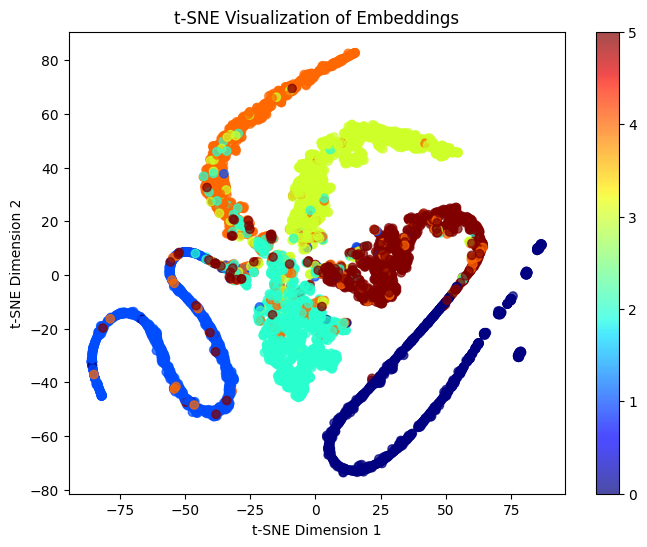

In [32]:
# Reduce dimensions using t-SNE for visualization
# Set perplexity to a value less than the number of samples, but greater than 0
perplexity_value = min(30, embeddings.shape[0] - 1)

# If perplexity_value is 0, set it to a minimum value (e.g., 5)
if perplexity_value == 0:
    perplexity_value = 5  # Or any other suitable value

# Initialize and fit t-SNE model
tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity_value)
reduced_embeddings = tsne.fit_transform(embeddings)

# Plot the t-SNE result with class labels
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c = labels.astype(int), cmap = 'jet', alpha = 0.7)
plt.colorbar(scatter)
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

In [33]:
print(f"Embeddings shape: {embeddings.shape}")
print(f"Labels shape: {labels.shape}")

print("Sample embeddings (first 2 rows):")
print(embeddings[:6])

print("Sample labels (first 10 labels):")
print(labels[:6]) 


unique_labels, counts = np.unique(labels, return_counts = True)
print("Unique classes and their counts:")
for label, count in zip(unique_labels, counts):
    print(f"Class {label}: {count} items")


Embeddings shape: (6000, 6)
Labels shape: (6000,)
Sample embeddings (first 2 rows):
[[9.99978662e-01 5.09597885e-06 3.76693606e-06 4.41579141e-06
  2.90296452e-06 5.17303124e-06]
 [9.99978781e-01 6.34372464e-06 3.12716770e-06 4.07845164e-06
  2.37745894e-06 5.32028844e-06]
 [9.99920368e-01 2.17126999e-05 1.50780488e-05 1.49804846e-05
  1.06350199e-05 1.73041062e-05]
 [9.99940634e-01 1.47729006e-05 8.57751093e-06 1.07904007e-05
  7.19757372e-06 1.80408333e-05]
 [1.00000000e+00 9.56980539e-09 7.33115701e-09 1.03000115e-08
  4.60073357e-09 1.14458922e-08]
 [9.99997139e-01 7.45199827e-07 4.61073995e-07 5.58723229e-07
  3.26874641e-07 7.74488512e-07]]
Sample labels (first 10 labels):
['0' '0' '0' '0' '0' '0']
Unique classes and their counts:
Class 0: 1000 items
Class 1: 1000 items
Class 2: 1000 items
Class 3: 1000 items
Class 4: 1000 items
Class 5: 1000 items
